In [1]:
# from ray tunning ---- ( 112, 85 , 29 , 1)    lr = 0.0027    batch size = 729 , weight decay = 0.001
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
df = pd.read_csv("/home/rs/21CS91R11/vikash/spin_Ai_data.csv", header = None)
df.drop([0],axis=1,inplace=True)
df.drop([0],axis=0,inplace=True)
Y = df[1].values
X= df.drop([1],axis=1).values
X

array([[6.15155225e+01, 1.77019550e+01, 3.01079624e+01, ...,
        1.00000000e+00, 1.28690639e-01, 0.00000000e+00],
       [7.61821667e+01, 7.08185000e+01, 4.39986178e+01, ...,
        0.00000000e+00, 3.42387423e-02, 0.00000000e+00],
       [1.37258302e+02, 6.25142100e+01, 5.68468823e+01, ...,
        0.00000000e+00, 1.11126397e-03, 0.00000000e+00],
       ...,
       [3.11530198e+01, 4.75466000e+01, 1.06343137e+04, ...,
        0.00000000e+00, 1.12969811e-05, 0.00000000e+00],
       [5.32710857e+01, 1.05760600e+02, 1.06425212e+04, ...,
        0.00000000e+00, 8.51221374e-04, 0.00000000e+00],
       [7.23233429e+01, 1.92981000e+02, 1.06479002e+04, ...,
        0.00000000e+00, 8.51217186e-04, 0.00000000e+00]])

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-0.66335731, -1.73901176, -0.60379505, ...,  2.50973972,
         0.38562249, -0.28951474],
       [-0.32542269, -0.7083139 , -0.60099031, ..., -0.39844769,
        -0.14287247, -0.28951474],
       [ 1.0818345 , -0.86945416, -0.59839603, ..., -0.39844769,
        -0.32823354, -0.28951474],
       ...,
       [-1.3629407 , -1.15989255,  1.53736555, ..., -0.39844769,
        -0.33438828, -0.28951474],
       [-0.85331764, -0.03028133,  1.53902277, ..., -0.39844769,
        -0.32968858, -0.28951474],
       [-0.41433398,  1.6621834 ,  1.54010887, ..., -0.39844769,
        -0.32968861, -0.28951474]])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# creating the train , validation , test data set in df 
x_train,x_temp, y_train , y_temp = train_test_split(X,Y ,test_size= 0.2 , random_state = 42)
x_test , x_val , y_test, y_val = train_test_split(x_temp , y_temp , test_size = 0.5 , random_state = 42)

In [7]:
# creating dataset and data_loader from df we have 
from torch.utils.data import Dataset , DataLoader

In [8]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

In [9]:
# creating custom dataset class 
class custom_dataset(Dataset):
    def __init__(self, inputs , targets):
        self.inputs = torch.tensor(inputs , dtype = torch.float )
        self.targets = torch.tensor(targets , dtype=torch.float)
         
    def __len__(self):
        return len(self.inputs) 
    
    def __getitem__(self,idx):
        input_item = self.inputs[idx]
        target_item = self.targets[idx]
        return input_item , target_item

In [10]:
train_dataset = custom_dataset(x_train,y_train)
val_dataset = custom_dataset(x_val,y_val)
test_dataset = custom_dataset(x_test,y_test)

In [11]:
# creating dataloader
train_dataloader = DataLoader(train_dataset , batch_size = 729 , shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 729 , shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = len(test_dataset) , shuffle = True )


In [12]:
# building the ANN model 

class ANN_model(nn.Module):
    def __init__(self, input_features = 112 , hidden1 = 85 , hidden2=29 ,out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2= nn.Dropout(p=0.5)
        self.out = nn.Linear(hidden2,out_features)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return torch.sigmoid(x)
        

In [13]:
# instance of model 
model = ANN_model()

In [14]:
model.parameters

<bound method Module.parameters of ANN_model(
  (fc1): Linear(in_features=112, out_features=85, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=85, out_features=29, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=29, out_features=1, bias=True)
)>

In [15]:
# instantiating the weights 
torch.manual_seed(20)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.0027, weight_decay=0.001)

In [16]:
# training the model 
epochs = 500
train_lossess = []
val_lossess = []
for epoch in range(epochs):
    epoch = epoch +1 
    # training the model 
    model.train()
    train_loss = 0.0 
    total_train_sample_size = len(train_dataset)
    for x_train , y_train in train_dataloader:
        output = model.forward(x_train)
        loss = loss_function(output, y_train)
        batchsize = x_train.size(0)
        train_loss =train_loss+ (loss.item()*batchsize)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #averaging the loss of each epoch 
    avg_train_loss = train_loss/total_train_sample_size 
    train_lossess.append(avg_train_loss)
    
    # validating the model 
    
    model.eval()
    val_loss = 0.0
    total_val_sample_size = len(val_dataset)
    with torch.no_grad():
         for x_val , y_val in val_dataloader:
                output = model(x_val)
                batchsize = x_val.size(0)
                loss = loss_function(output,y_val)
                val_loss = val_loss + (loss.item()*batchsize)
    # averaging the validation loss of each epoch 
    avg_val_loss = val_loss/total_val_sample_size
    if epoch%100 == 1 :
        print('epoch is {} , train_loss is {} , val_loss is {}'.format(epoch, avg_train_loss , avg_val_loss))
    val_lossess.append(avg_val_loss) 

/home/rs/21CS91R11/anaconda3/envs/envpytorch3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([729])) that is different to the input size (torch.Size([729, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/rs/21CS91R11/anaconda3/envs/envpytorch3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([208])) that is different to the input size (torch.Size([208, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/rs/21CS91R11/anaconda3/envs/envpytorch3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])) is deprecated. Please ensure they have the same size.
  re

epoch is 1 , train_loss is 0.6335383993069167 , val_loss is 0.49961499604817383
epoch is 101 , train_loss is 0.21594267888500665 , val_loss is 0.2580747790308805
epoch is 201 , train_loss is 0.18919007584291428 , val_loss is 0.25361087727129633
epoch is 301 , train_loss is 0.1759580166357697 , val_loss is 0.26369666714362433
epoch is 401 , train_loss is 0.1697573365827689 , val_loss is 0.26614343798542855


Text(0, 0.5, 'losses')

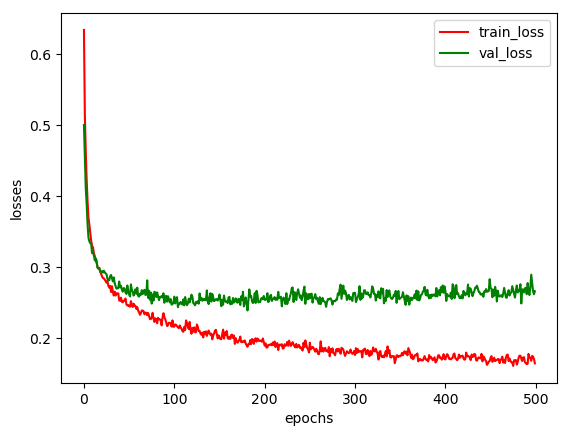

In [17]:
plt.plot(range(epochs), train_lossess , 'r' , label = 'train_loss')
plt.plot(range(epochs), val_lossess , 'g' , label = 'val_loss')
plt.legend()
plt.xlabel('epochs') 
plt.ylabel('losses')

In [18]:
# prediction on test dataset 
predictions =[]
with torch.no_grad():
    for x_test , y_test in test_dataloader:
        output = model(x_test)
        y_pred = torch.round(output).squeeze(1).numpy()
        print(y_pred) 
        

[0. 0. 0. ... 1. 0. 0.]


In [19]:
y_test_check = y_test.numpy()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score

In [21]:
print(accuracy_score(y_test_check,y_pred))
print(confusion_matrix(y_test_check,y_pred , normalize = 'all'))
print(classification_report(y_test_check,y_pred))   

0.9114785992217899
[[0.68385214 0.03501946]
 [0.05350195 0.22762646]]
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       739
         1.0       0.87      0.81      0.84       289

    accuracy                           0.91      1028
   macro avg       0.90      0.88      0.89      1028
weighted avg       0.91      0.91      0.91      1028



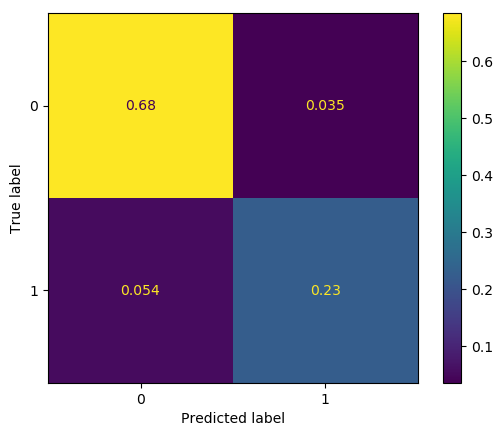

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
#ConfusionMatrixDisplay.from_predictions( y_test, y_pred,normalize='all')
#plt.show()

cm = confusion_matrix(y_test_check,y_pred, normalize = 'all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [23]:
predictions = []
y_test_list = []
model.eval()
for i in range(len(test_dataset)):
    input_item , target_item = test_dataset[i]
    output = model(input_item)
    y_pred = output.item()
    y_pred = 1 if y_pred>=0.5 else 0
    predictions.append(y_pred)
    y_test_list.append(int(target_item.item()))

In [24]:
accuracy_score(predictions,y_test_list)
    

0.9114785992217899

In [25]:
dfxx = pd.DataFrame(predictions)

In [26]:
dfxx2 = pd.DataFrame(y_test_list)

In [27]:
dfxx['y_test'] = dfxx2[0]

In [28]:
dfxx

,0,y_test
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0
